## Model Selection
Now, we have a zoo of performance measures, we have discussed that we should avoid to optimize our models and its hyperparameters only on a subset of observations (i.e. the *training set*), but we should use the *testing set* only to asses the final performance of the *model*.

In this notebook we'll see how to estimate the *test accuracy* (or any other model performance measure) leveraging only on the *training set* and, as a consequence, how to find a right **bias - variance tradeoff** while searching the right model and the right *hyper parameters*.

### Validation Set Approach
The first simple way to estimate the *test error* from the *training set* is to split it in two subsets:
* The **real** *training set* on which the model is fitted.
* A *validation set* used to estimate the *test error*

Let's try this simple strategy on the titanic dataset, but first let's fit this dataset using **KKNN** with $k = 5$ on the whole *training set* and compute the *training error* and the *test error*

In [11]:
source("src/lib.R")
source("src/titanic/titanic_dataset.R")

titanic_df <- get_titanic_df()

model <-  train(
    y = titanic_df$y_train$class,
    x = titanic_df$x_train,
    method = "kknn",
    ks = 5,
    trControl = trainControl(classProbs =  TRUE, method = "none"),
    tuneGrid = data.frame(
          kmax = 1,
          distance = 2,
          kernel = 'rectangular'
      )
)

(full_train_error <- confusionMatrix(predict(model, titanic_df$x_train), titanic_df$y_train$class)$overall["Accuracy"])
(full_test_error <- confusionMatrix(predict(model, titanic_df$x_test), titanic_df$y_test$class)$overall["Accuracy"])

Accuracy 
0.8409586

Accuracy 
0.7704082

Now let's use **CARET** to directly estimate the *test error* using the *validation set* approach:

In [12]:
## Let's split the training set in two partitions of equal size
set.seed(21)
full_indices <- 1:nrow(titanic_df$x_train)
validation_set <- sample(full_indices, length(full_indices) / 2)
small_train_set <- full_indices[!(full_indices %in% validation_set)]

## Let's instruct CARET to use the small_train_set to estimate the accuracy and the validation_set to train it
model <-  train(
  y = titanic_df$y_train$class,
  x = titanic_df$x_train,
  method = "kknn",
  ks = 5,
  trControl = trainControl(
    classProbs =  TRUE, 
    method = "cv",
    index = list(sample = small_train_set),
    indexOut = list(sample = validation_set),
    indexFinal = small_train_set
  ),
  tuneGrid = data.frame(
    kmax = 1,
    distance = 2,
    kernel = 'rectangular'
  )
)

## Compute the accuracy on the small train set and on validation
confusionMatrix(predict(model, titanic_df$x_train[small_train_set,]), titanic_df$y_train[small_train_set,]$class)$overall["Accuracy"]
confusionMatrix(predict(model, titanic_df$x_train[validation_set,]), titanic_df$y_train[validation_set,]$class)$overall["Accuracy"]

Accuracy 
0.8474946

Accuracy 
0.7930283

It worked! The estimation of our *testing error* is 0.79 nearer to the real value of 0.77 than 0.84. Note that this same measure can be directly extracted from the *train* function output:

In [13]:
model$results$Accuracy

[1] 0.7930283

Ok...we have found a way to estimate the *testing error*...how good is this estimation varying $K$?

In [22]:
res_df <- data_frame()
for(k in seq(1,25)) {
  model <-  train(
    y = titanic_df$y_train$class,
    x = titanic_df$x_train,
    method = "kknn",
    ks = k,
    trControl = trainControl(
      classProbs =  TRUE, 
      method = "cv",
      index = list(sample = small_train_set),
      indexOut = list(sample = validation_set)
    ),
    tuneGrid = data.frame(
      kmax = 1,
      distance = 2,
      kernel = 'rectangular'
    )
  )
  res_df <- rbind(
    res_df,
    data_frame(
      k = k, 
      validation_error = model$results$Accuracy, 
      test_error = confusionMatrix(predict(model, titanic_df$x_test), titanic_df$y_test$class)$overall["Accuracy"],
      train_error = confusionMatrix(predict(model, titanic_df$x_train), titanic_df$y_train$class)$overall["Accuracy"],
    )
  )
}

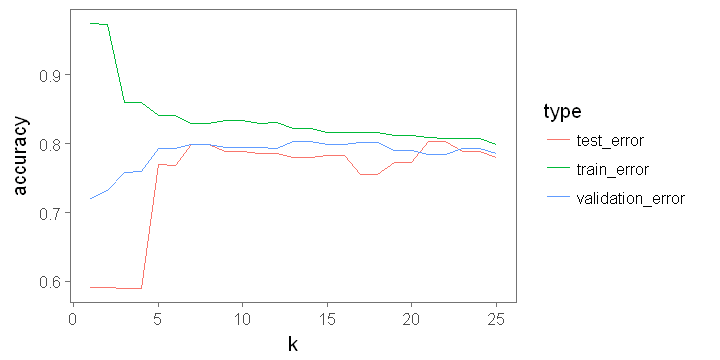

In [23]:
options(repr.plot.width=6, repr.plot.height=3) ### set a small plot size

res_df %>% gather(type, accuracy, -k) %>%
  ggplot(aes(x = k, y = accuracy, color = type)) +
  geom_line() + theme_few()

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


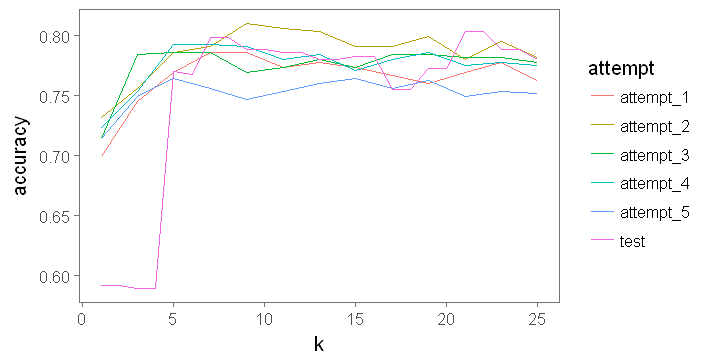

In [24]:
multi_res_df <- data_frame()
for(attempt in 1:5) {
  print(attempt)
  validation_set <- sample(full_indices, length(full_indices) / 2)
  small_train_set <- full_indices[!(full_indices %in% validation_set)]
  for(k in seq(1,25,2)) {
    model <-  train(
      y = titanic_df$y_train$class,
      x = titanic_df$x_train,
      method = "kknn",
      ks = k,
      trControl = trainControl(
        classProbs =  TRUE, 
        method = "cv",
        index = list(sample = small_train_set),
        indexOut = list(sample = validation_set)
      ),
      tuneGrid = data.frame(
        kmax = 1,
        distance = 2,
        kernel = 'rectangular'
      )
    )
    multi_res_df <- rbind(
      multi_res_df,
      data_frame(
        k = k,
        attempt = attempt,
        accuracy = model$results$Accuracy, 
      )
    )
  }
}

multi_res_df %>% mutate(attempt = str_c("attempt_", attempt)) %>%
  rbind(res_df %>% select(k,accuracy = test_error) %>% mutate(attempt = "test")) %>%
  ggplot(aes(x = k, y = accuracy, color = attempt)) +
  geom_line() + theme_few()


##### K Fold Validation
##### Leave one out Cross Validation

#### Ensembling

In [ ]:
)